# Weather in Norway
This code retrieves, parse_dlys and plots weather data from different weather stations in Norway 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pp
import urllib.request

### 1. Getting data from FTP using request

Using request library to retrieve data from U.S. NOAA Climate Data Online service and specifically from URLs 
https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/

 - Retrieving metada with information about DAILY GLOBAL HISTORICAL CLIMATOLOGY NETWORK (GHCN-DAILY), how to download the data, contents and formats of data files
 - Retrieving stations.txt that contains list of stations and their metadata (e.g., coordinates)
 - Retrieving .dly files which is the data Global Surface Network (GSN)
 - Retrieving ghcnd-countries.txt with country codes

In [2]:
urllib.request.urlretrieve('ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt','readme.txt')
urllib.request.urlretrieve('ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt','stations.txt')
urllib.request.urlretrieve('ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd_gsn.tar.gz','ghcnd_gsn.tar.gz')
urllib.request.urlretrieve('ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt','ghcnd-countries.txt')

('ghcnd-countries.txt', <email.message.Message at 0x7fd767495b20>)

- Unzipping the data

In [82]:
#!tar xzvf ghcnd_gsn.tar.gz

stations.txt header is code, latitude, longitude, elevation, name, GSN flag, World Meteorological Organization ID 

### Function to make a dictionary only with metadata of stations

In [5]:
def get_stations():
    open('stations.txt','r').readlines()[:10]
    stations = {}

    for line in open('stations.txt','r'):  # read every line of stations
        if 'GSN' in line:
            fields = line.split()
            stations[fields[0]] = ' '.join(fields[4:])  # columns name and location of the station
    return stations

In [81]:
list(get_stations().items())[:10]

[('AE000041196', 'SHARJAH INTER. AIRP GSN 41196'),
 ('AF000040930', 'NORTH-SALANG GSN 40930'),
 ('AG000060390', 'ALGER-DAR EL BEIDA GSN 60390'),
 ('AG000060590', 'EL-GOLEA GSN 60590'),
 ('AG000060611', 'IN-AMENAS GSN 60611'),
 ('AG000060680', 'TAMANRASSET GSN 60680'),
 ('AJ000037989', 'ASTARA GSN 37989'),
 ('ALM00013615', 'TIRANA RINAS GSN 13615'),
 ('AM000037781', 'ARAGAC VISOKOGORNAYA GSN 37781'),
 ('AO000066160', 'LUANDA GSN 66160')]

### Function to find station knowing the name

In [7]:
def findstation(s):
    found = {code: name for code,name in get_stations().items() if s in name}
    print(found)

In [8]:
findstation('TROMSO')

{'NO000001026': 'TROMSO GSN 01026'}


### Function to find stations knowing the country code

Opening the ghcnd-countries.txt to find the norwegian code

In [9]:
open('ghcnd-countries.txt','r').readlines()[:10]

['AC Antigua and Barbuda \n',
 'AE United Arab Emirates \n',
 'AF Afghanistan\n',
 'AG Algeria \n',
 'AJ Azerbaijan \n',
 'AL Albania\n',
 'AM Armenia \n',
 'AO Angola \n',
 'AQ American Samoa [United States] \n',
 'AR Argentina \n']

In [10]:
def findstation_country(s):
    found_country = {code: name for code,name in get_stations().items() if code.startswith(s)}
    print(found_country)

In [11]:
findstation_country('NO')

{'NO000001026': 'TROMSO GSN 01026', 'NO000001212': 'ONA HUSOY GSN 01212', 'NO000001465': 'TORUNGEN FYR GSN 01465', 'NO000011520': 'BODO VI GSN 01152', 'NO000014030': 'UTSIRA FYR GSN 01403', 'NO000098550': 'VARDO GSN 01098', 'NO000099710': 'BJOERNOEYA GSN 01028', 'NOM00001238': 'FOKSTUA GSN 01238'}


Making a list of all stations in Norway

Opening the first 10 lines of the dly file

In [58]:
r=open('NO000001026.dly','r').readlines()[:50]

In [69]:
r[0]

'NO000001026192007TMIN  104  E   82  E   90  E   72  E   57  E   81  E  140  E  130  E  141  E   87  E   91  E   77  E   84  E  106  E  101  E   99  E  113  E  105  E   93  E   69  E   61  E   62  E   80  E   82  E   93  E   85  E   81  E   72  E   66  E   73  E  111  E\n'

Opening the readme to read the format of the .dly data file

In [13]:
open('readme.txt','r').readlines()[98:121]

['\n',
 'III. FORMAT OF DATA FILES (".dly" FILES)\n',
 '\n',
 'Each ".dly" file contains data for one station.  The name of the file\n',
 'corresponds to a station\'s identification code.  For example, "USC00026481.dly"\n',
 'contains the data for the station with the identification code USC00026481).\n',
 '\n',
 'Each record in a file contains one month of daily data.  The variables on each\n',
 'line include the following:\n',
 '\n',
 '------------------------------\n',
 'Variable   Columns   Type\n',
 '------------------------------\n',
 'ID            1-11   Character\n',
 'YEAR         12-15   Integer\n',
 'MONTH        16-17   Integer\n',
 'ELEMENT      18-21   Character\n',
 'VALUE1       22-26   Integer\n',
 'MFLAG1       27-27   Character\n',
 'QFLAG1       28-28   Character\n',
 'SFLAG1       29-29   Character\n',
 'VALUE2       30-34   Integer\n',
 'MFLAG2       35-35   Character\n']

### Function to parse the dly file

In [14]:
def parse_dly(filename):
    return np.genfromtxt(filename,
                         delimiter = dly_delimiter,
                         usecols = dly_usecols,
                         dtype = dly_dtype,
                         names = dly_names)

In [15]:
dly_delimiter=[11,4,2,4]+[5,1,1,1]*31 #ID, year,month,element + value and flags
dly_usecols=[1,2,3]+[4*i for i in range(1,32)] #year, month, element, value 1 , value 2, ..., value 31
dly_dtype=[np.int32,np.int32,(np.str_,4)]+[np.int32]*31 #data types for year, month, element, value
dly_names=['year','month','obs']+[str(day) for day in range(1,31+1)]

In [16]:
tromso = parse_dly('NO000001026.dly')

In [57]:
tromso[0]

(1920, 7, 'TMIN', 104, 82, 90, 72, 57, 81, 140, 130, 141, 87, 91, 77, 84, 106, 101, 99, 113, 105, 93, 69, 61, 62, 80, 82, 93, 85, 81, 72, 66, 73, 111)

### Function to convert to format date, month and year

In [18]:
def date_format(record):
    startdate = np.datetime64('{}-{:02}'.format(record['year'],record['month']))
    dates = np.arange(startdate,startdate + np.timedelta64(1,'M'),np.timedelta64(1,'D'))
    
    rows = [(date,record[str(i+1)]/10) for i,date in enumerate(dates)]
    return np.array(rows,dtype=[('date','M8[D]'),('value','d')])
   

In [19]:
date_format(tromso[0])

array([('1920-07-01', 10.4), ('1920-07-02',  8.2), ('1920-07-03',  9. ),
       ('1920-07-04',  7.2), ('1920-07-05',  5.7), ('1920-07-06',  8.1),
       ('1920-07-07', 14. ), ('1920-07-08', 13. ), ('1920-07-09', 14.1),
       ('1920-07-10',  8.7), ('1920-07-11',  9.1), ('1920-07-12',  7.7),
       ('1920-07-13',  8.4), ('1920-07-14', 10.6), ('1920-07-15', 10.1),
       ('1920-07-16',  9.9), ('1920-07-17', 11.3), ('1920-07-18', 10.5),
       ('1920-07-19',  9.3), ('1920-07-20',  6.9), ('1920-07-21',  6.1),
       ('1920-07-22',  6.2), ('1920-07-23',  8. ), ('1920-07-24',  8.2),
       ('1920-07-25',  9.3), ('1920-07-26',  8.5), ('1920-07-27',  8.1),
       ('1920-07-28',  7.2), ('1920-07-29',  6.6), ('1920-07-30',  7.3),
       ('1920-07-31', 11.1)], dtype=[('date', '<M8[D]'), ('value', '<f8')])

### Function to gather the rows that contain a specific observation (TMIN, PRCP, SNWD..) from a station file

In [20]:
def getobs(filename,obs):
    data = np.concatenate([date_format(row) for row in parse_dly(filename) if row[2] == obs])
    
    data['value'][data['value'] == -999.9] = np.nan #replace missing data for nan
    
    return data 

In [21]:
getobs('NO000001026.dly','TMIN')

array([('1920-07-01', 10.4), ('1920-07-02',  8.2), ('1920-07-03',  9. ),
       ..., ('2022-03-29',  nan), ('2022-03-30',  nan),
       ('2022-03-31',  nan)], dtype=[('date', '<M8[D]'), ('value', '<f8')])

In [22]:
tromso_tmax = getobs('NO000001026.dly','TMAX')
tromso_tmin = getobs('NO000001026.dly','TMIN')

## Visualization

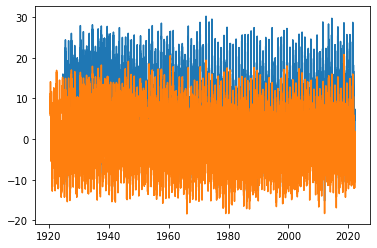

In [23]:
pp.plot(tromso_tmax['date'],tromso_tmax['value'])
pp.plot(tromso_tmin['date'],tromso_tmin['value'])

In [24]:
tromso_tmin['value'].mean()

nan

In [25]:
np.mean(tromso_tmin['value']), np.mean(tromso_tmax['value'])

(nan, nan)

### Function to interpolate missing data

In [26]:
def fillnans(data):
    dates_float = data['date'].astype(np.float64)   #converting to float
    nan = np.isnan(data['value'])
    data['value'][nan] = np.interp(dates_float[nan],dates_float[~nan],data['value'][~nan]) #interpolate missing data with neighbor values

In [27]:
fillnans(tromso_tmax)
fillnans(tromso_tmin)

In [47]:
type(tromso_tmin['value'])

numpy.ndarray

In [28]:
np.mean(tromso_tmin['value']), np.mean(tromso_tmax['value'])

(0.4580292756430955, 5.560723604837126)

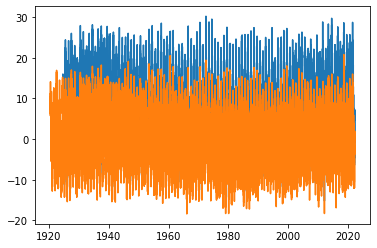

In [29]:
pp.plot(tromso_tmax['date'],tromso_tmax['value'])
pp.plot(tromso_tmin['date'],tromso_tmin['value'])

### Function to smooth the curves for better visualization

In [118]:
def plot_smoothed(t,win=10): #average smooth function
    smoothed = np.correlate(t['value'],np.ones(win)/win,'same')
    
    pp.plot(t['date'],smoothed)

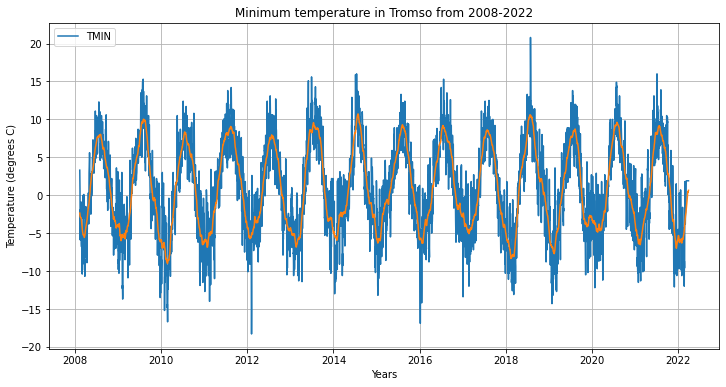

In [125]:
pp.figure(figsize=(12,6))
pp.plot(tromso_tmin[32000:39000]['date'],tromso_tmin[32000:39000]['value'], label="TMIN")

plot_smoothed(tromso_tmin[32000:39000],50)
pp.title('Minimum temperature in Tromso from 2008-2022')
pp.ylabel('Temperature (degrees C)')
pp.xlabel('Years')
pp.legend(loc="upper left")
pp.grid(visible='True')

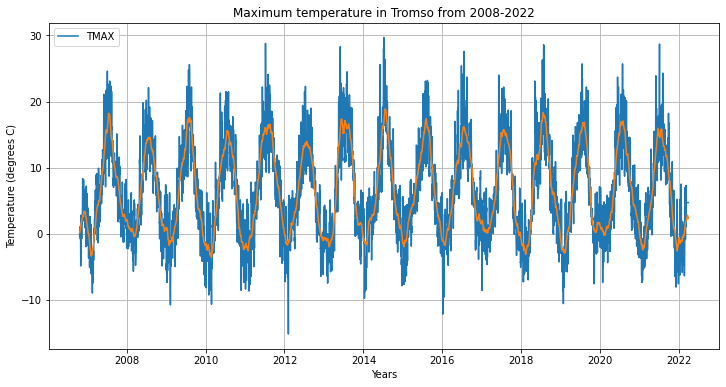

In [124]:
pp.figure(figsize=(12,6))
pp.plot(tromso_tmax[30000:37000]['date'],tromso_tmax[30000:37000]['value'], label="TMAX")

plot_smoothed(tromso_tmax[30000:37000],50)
pp.title('Maximum temperature in Tromso from 2008-2022')
pp.ylabel('Temperature (degrees C)')
pp.xlabel('Years')
pp.legend(loc="upper left")
pp.grid(visible='True')

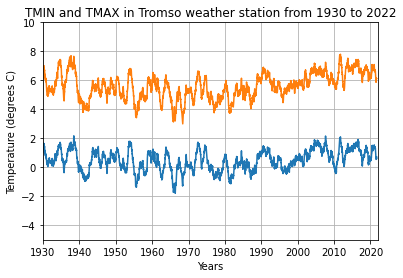

In [128]:
plot_smoothed(getobs('NO000001026.dly','TMIN'),365)
plot_smoothed(getobs('NO000001026.dly','TMAX'),365)

pp.title('TMIN and TMAX in Tromso weather station from 1930 to 2022')
pp.axis(xmin=np.datetime64('1930'),xmax=np.datetime64('2022'),ymin=-5,ymax=10)
pp.ylabel('Temperature (degrees C)')
pp.xlabel('Years')
pp.grid(visible='True')